<a href="https://colab.research.google.com/github/ayoubbensakhria/finance_algo/blob/master/ARMA_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An ARMA model, or Autoregressive Moving Average model, is used to describe weakly stationary stochastic time series in terms of two polynomials. The first of these polynomials is for autoregression, the second for the moving average.

Often this model is referred to as the ARMA(p,q) model; where:

* p is the order of the autoregressive polynomial,
* q is the order of the moving average polynomial.

The equation is given by:

\begin{align}
        \mathbf{x_t} = \mathbf{w_t} + \sum_{i=1}^q \alpha_i x_{t-i} + \sum_{i=1}^p \beta_i w_{t-i}
        &
    \end{align}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from time import time
%matplotlib inline
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Vizualise the Stock Price Over Time

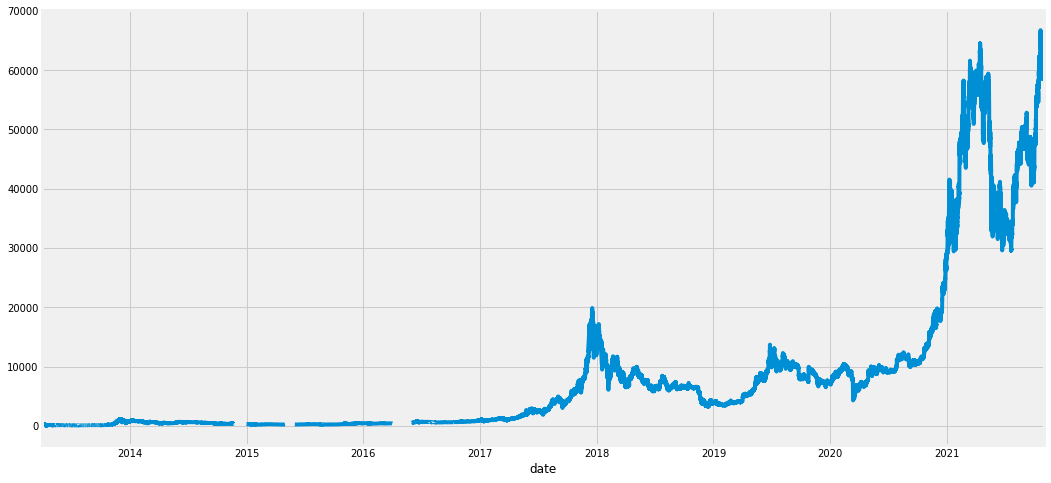

In [2]:
#read data
df = pd.read_csv('/content/drive/MyDrive/Yoctobe Fintech/Datasets/btcusd30mn.csv', parse_dates=True)
df.head()
# #setting index as date because some statsmodels might not work
df.rename(columns={'datetime': 'date'}, inplace=True)
df.index = df['date']
df.index = pd.to_datetime(df.index)
#plot
df['close'].plot(figsize=(16,8))

In [ ]:
df = df.drop(columns =['open', 'high', 'low', 'volume', 'date'])
df.head()

,close
date,
2013-04-01 00:00:00,94.120499
2013-04-01 00:30:00,93.250000
2013-04-01 01:00:00,93.422576
2013-04-01 01:30:00,93.100000
2013-04-01 02:00:00,93.189997


# Identify the correct ARMA Model Order
## Visualising ACF Plot and PACF Plots
The bars inside the blue shaded region then they are not statistically significant.
* PACF is the autocorrelation that is just associated with just k lags
* PACF cuts off after lag k = q; ACF cuts off after lag k = p; 

"Cuts off" means that it becomes zero abruptly, and "tails off" means that it decays to zero asymptotically (usually exponentially).

The PACF "cuts off" after the 2nd lag, while the ACF "tails off" to zero. You probably have something like an AR(2).



In [4]:
ddf = df.resample("D").mean()
# using a range of dates
mask = (ddf.index > '2018-01-01') & (ddf.index <= '2019-01-01')
ddf = ddf.loc[mask]

# Tain Dataset

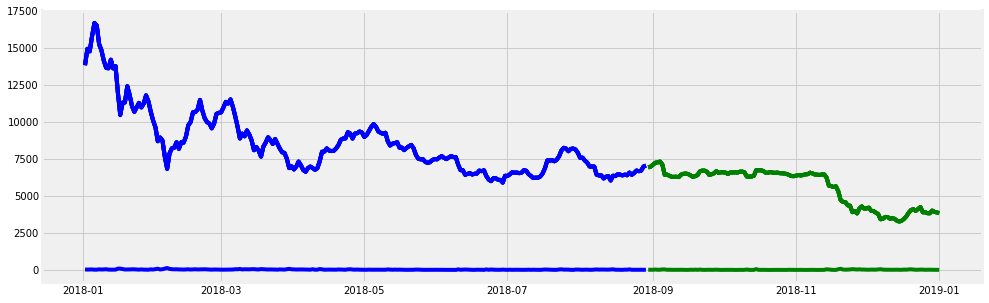

In [10]:
# using scikitlearn to split the dataset into 80% training and 20% validation datasets 
df_train, df_valid = train_test_split(ddf, train_size = 0.66, shuffle=False)

plt.figure(figsize=(15,5))
plt.plot(df_train, color='blue')
plt.plot(df_valid, color='green')


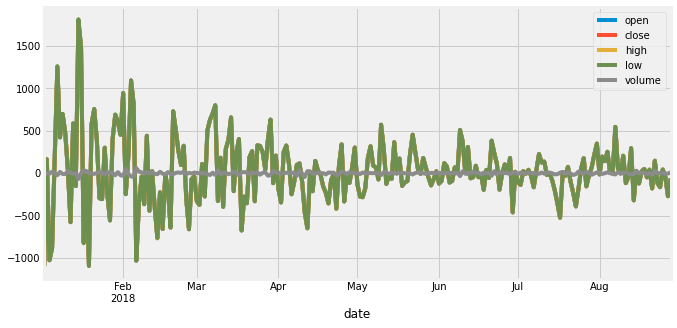

In [11]:

# Difference the stock price and make it stationary
# A stationary process has the property that the mean, 
# variance and autocorrelation structure do not change over time.
df1_train = df_train - df_train.shift(-1)
df1_train.dropna(inplace=True)
df1_train.plot(figsize = (10,5))


# Stationarity
Mathimatically, stationarity of a time series is defined as the requirement that for every m and n, the distributions: \begin{align}
        \mathbf (Y_1, Y_2, Y_3, ..., Y_n) \\and\\  (Y_{1+m}, Y_{2+m}, Y_{3+m}, ..., Y_{n+m})
        &
    \end{align} are the same.

Strong stationarity : all the aspects of the stochastic process remain unchanged, constant in time.
Weak stationarity : only mean, variance, and covariance remain unchanged.
The simplest example of weakly stationary process is White Noise defined with increasingly restrictive assumptions: 
\begin{align}
 \mathbf E(Y_t) = {μ} \\  Var(Y_t) = σ^2 \\  Cov(Y_t, Y_s) = 0
        &
    \end{align}

Where the best predictor is the Mean.

##Dickey–Fuller test
Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model.

In [12]:
#test stationarity
print('Results of Dickey-Fuller Test:')
dftest = sm.tsa.adfuller(df1_train['close'])
dfoutput = pd.Series(dftest[0:4], 
                     index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -5.017554
p-value                          0.000020
#Lags Used                       7.000000
Number of Observations Used    231.000000
Critical Value (1%)             -3.458980
Critical Value (5%)             -2.874135
Critical Value (10%)            -2.573482
dtype: float64


# Plot ACF PACF

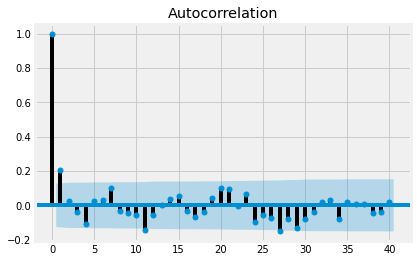

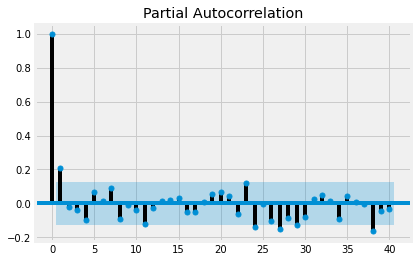

In [21]:
acf = sm.tsa.graphics.plot_acf(df1_train['close'], lags=40)
pacf = sm.tsa.graphics.plot_pacf(df1_train['close'], lags=40)

In [22]:
#By selecting aic as criteria, decide the order.
sm.tsa.stattools.arma_order_select_ic(df1_train['close'], ic='aic')

{'aic':              0            1            2
 0  3527.966322  3519.162893  3521.029716
 1  3519.142351  3521.137288  3518.874472
 2  3521.002902  3518.315797  3520.243528
 3  3522.766855  3524.346319  3520.235105
 4  3522.553110  3520.380341  3523.303704, 'aic_min_order': (2, 1)}

In [28]:
#fit the model_1
mod = sm.tsa.ARIMA(df_train['close'], order = (2,1, 1), freq='D')
result = mod.fit()
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  239
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1754.158
Method:                       css-mle   S.D. of innovations            372.391
Date:                Fri, 12 Nov 2021   AIC                           3518.316
Time:                        11:28:41   BIC                           3535.698
Sample:                    01-03-2018   HQIC                          3525.320
                         - 08-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -26.8961     30.235     -0.890      0.375     -86.156      32.364
ar.L1.D.close    -0.7095      0.072     -9.810      0.000      -0.851      -0.568
ar.L2.D.close     0.1510      0.068     

In [29]:
#fit the model_1
mod1 = sm.tsa.ARIMA(df_train['close'], order = (1,1,1), freq='D')
result1 = mod1.fit()
print(result1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  239
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1756.569
Method:                       css-mle   S.D. of innovations            376.148
Date:                Fri, 12 Nov 2021   AIC                           3521.137
Time:                        11:28:48   BIC                           3535.043
Sample:                    01-03-2018   HQIC                          3526.741
                         - 08-29-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -27.7315     26.248     -1.057      0.292     -79.176      23.713
ar.L1.D.close    -0.7926      0.085     -9.372      0.000      -0.958      -0.627
ma.L1.D.close     0.9341      0.051     

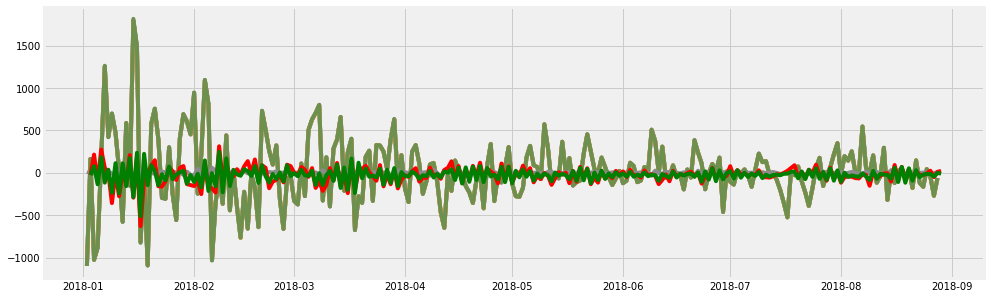

In [30]:
plt.figure(figsize=(15,5))
plt.plot(df1_train)
plt.plot(result.fittedvalues, color='red')
plt.plot(result1.fittedvalues, color='green')
plt.show()

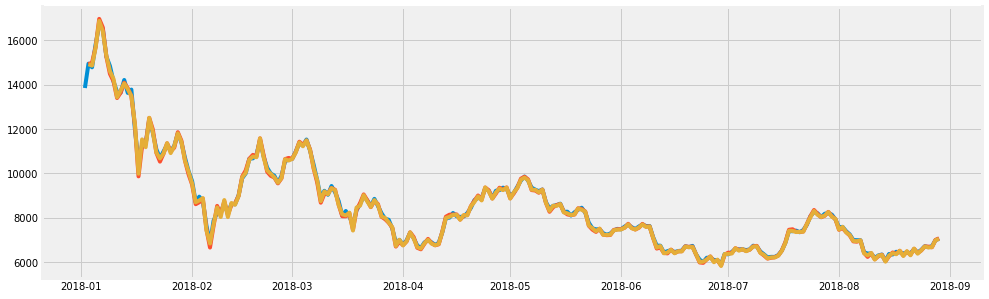

In [31]:
#take back to original scale
df_estimated = pd.DataFrame(result.fittedvalues,columns=['close'],copy=False)
df_origin = df_estimated['close'] + df_train['close']
df_origin.dropna(inplace=True)

#take back to original scale model_2
df1_estimated = pd.DataFrame(result1.fittedvalues,columns=['close'],copy=False)
df1_origin = df1_estimated['close'] + df_train['close']
df1_origin.dropna(inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df_train['close'])
plt.plot(df_origin)
plt.plot(df1_origin)
plt.show()

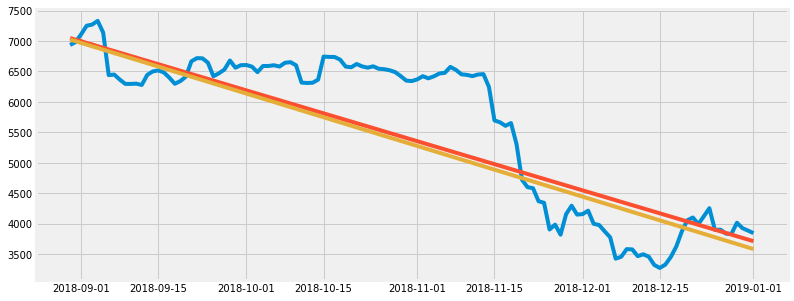

In [32]:
#make predictions and compared it to the validation dataset
forecast = pd.DataFrame(result.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

#make predictions and compared it to the validation dataset
forecast1 = pd.DataFrame(result1.forecast(len(df_valid['close']))[0],
                        columns=['forecasted values'], index=df_valid.index)

plt.figure(figsize=(12,5))
plt.plot(df_valid['close'])
plt.plot(forecast['forecasted values'])
plt.plot(forecast1['forecasted values'])
plt.show()

In [35]:
df_diff = ddf - ddf.shift(-1)
df_diff.dropna(inplace = True)

#fit the model to the whole dataset
model_final = sm.tsa.ARIMA(ddf['close'], order = (1,1,2), freq = 'D')
result_final = model_final.fit()
print(result_final.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  364
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -2611.357
Method:                       css-mle   S.D. of innovations            315.717
Date:                Fri, 12 Nov 2021   AIC                           5232.715
Time:                        11:30:17   BIC                           5252.201
Sample:                    01-03-2018   HQIC                          5240.459
                         - 01-01-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -26.7020     19.903     -1.342      0.181     -65.711      12.307
ar.L1.D.close    -0.9057      0.059    -15.394      0.000      -1.021      -0.790
ma.L1.D.close     1.1282      0.077     

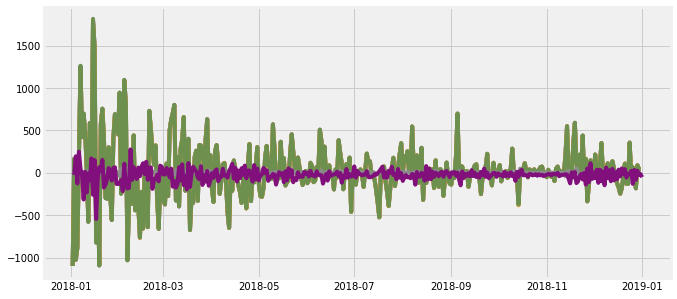

In [36]:
plt.figure(figsize=(10,5))
plt.plot(df_diff)
plt.plot(result_final.fittedvalues)
plt.show()

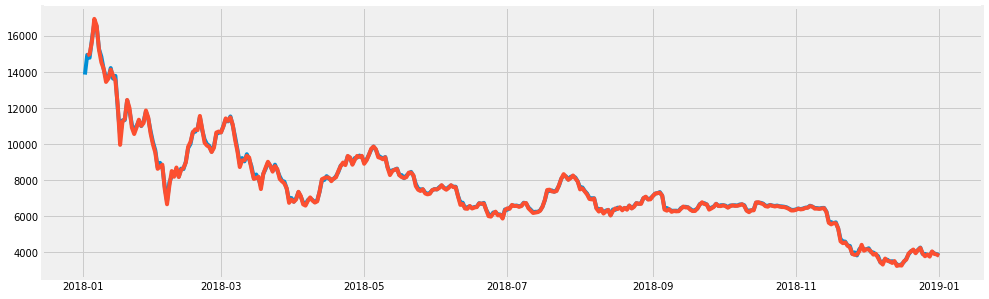

In [37]:
df_estimated_final = pd.DataFrame(result_final.fittedvalues,columns=['close'],copy=False)
df_origin_final = df_estimated_final['close'] + ddf['close']
df_origin_final.dropna(inplace=True)
plt.figure(figsize=(15,5))
plt.plot(ddf['close'])
plt.plot(df_origin_final)
plt.show()

In [38]:
df_origin_final

date
2018-01-03    14917.954146
2018-01-04    14975.161657
2018-01-05    15682.603369
2018-01-06    16938.700818
2018-01-07    16567.346030
                  ...     
2018-12-28     3751.903276
2018-12-29     4041.462856
2018-12-30     3903.217952
2018-12-31     3871.946903
2019-01-01     3794.736761
Freq: D, Name: close, Length: 364, dtype: float64

In [39]:
result_actual = df.resample('D').mean()
mask = (result_actual.index > '2021-01-01') & (result_actual.index <= '2021-03-01')
result_actual = result_actual.loc[mask]
forcast_date_range = result_actual.index.to_numpy()

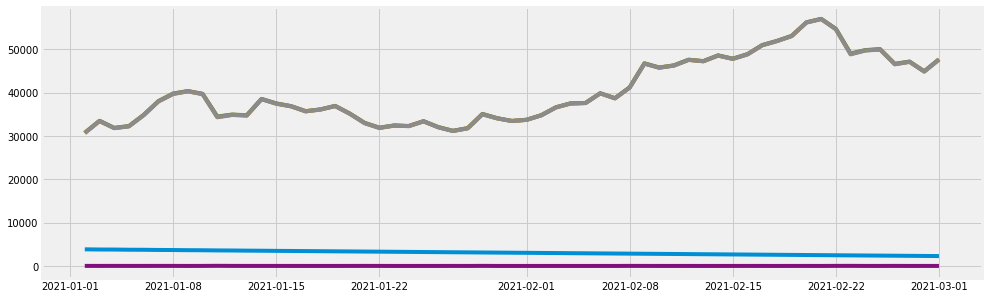

In [40]:
forecast_final = pd.DataFrame(result_final.forecast(steps=59)[0], columns= ['forcasetd values'], index=forcast_date_range)
forecast_final['forcasetd values']
plt.figure(figsize=(15,5))
plt.plot(forecast_final)
plt.plot(result_actual)
plt.show()
